## Lab 8:  Clustering
Environmental justice (EJ) seeks to ensure that all communities, regardless of socioeconomic status or demographic background, have equal access to clean air, water, and, in the form of energy justice, access to renewable energy resources while minimizing exposure to environmental hazards. In this lab, we will apply clustering analysis to explore how U.S. counties group together based on renewable energy potential, demographic characteristics, and environmental risk factors.

The EEIP dataset was collated by the National Renewable Energy Lab (NREL) and contains a large set of features from multiple other databases including SLOPE (renewable energy potential) and EJSCREEN (environmental risk indicators).

Link to metadata: https://ucsb.box.com/s/x3olvh3rd8w5h7xz8jnm3v8g3t4ajjsg

First you will step through a guided clustering exploration of renewable energy production potential.  Then you will formulate a question of your own that brings in an environmental justice component.


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from tabulate import tabulate 
import seaborn as sns

# Load the EEIP dataset 
eeip_data = pd.read_csv("data/eeip.data.csv")

In [2]:
eeip_data

,county_fips,county,state,county_pop,utilitypv_techpot_quint,utility_pv_technical_generation_potential_mwh,residentialpv_techpot_quint,residential_pv_technical_generation_potential_mwh,landbasedwind_techpot_quint,land_based_wind_technical_generation_potential_mwh,...,rmpprox_2_prop,rmpprox_3_prop,rmpprox_4_prop,rmpprox_5_prop,tsdf_indicator,tsdfprox_1_prop,tsdfprox_2_prop,tsdfprox_3_prop,tsdfprox_4_prop,tsdfprox_5_prop
0,1001,Autauga,AL,55200,3,3.585222e+07,4.0,122752.69,3,4.374954e+06,...,0.156250,0.031250,0.000000,0.000000,0.0,0.343750,0.187500,0.281250,0.156250,0.031250
1,1003,Baldwin,AL,208107,5,1.257822e+08,5.0,483008.57,3,4.368632e+06,...,0.127660,0.031915,0.053191,0.000000,0.0,0.521277,0.297872,0.159574,0.021277,0.000000
2,1005,Barbour,AL,25782,4,6.614827e+07,3.0,42823.79,3,5.898865e+06,...,0.173913,0.304348,0.130435,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
3,1007,Bibb,AL,22527,2,1.926909e+07,2.0,37917.84,3,3.986770e+06,...,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.600000,0.066667,0.000000,0.000000
4,1009,Blount,AL,57645,2,2.261702e+07,4.0,122024.81,3,6.117475e+06,...,0.085714,0.057143,0.000000,0.000000,0.0,0.714286,0.171429,0.114286,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,56037,Sweetwater,WY,44117,5,1.028709e+09,4.0,92790.23,5,2.032127e+08,...,0.117647,0.000000,0.323529,0.029412,0.0,0.088235,0.411765,0.411765,0.058824,0.029412
3104,56039,Teton,WY,23059,1,5.383872e+06,2.0,33922.11,1,4.040734e+05,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
3105,56041,Uinta,WY,20609,5,1.290202e+08,2.0,40010.06,5,3.105440e+07,...,0.000000,0.250000,0.250000,0.187500,0.0,0.812500,0.062500,0.125000,0.000000,0.000000
3106,56043,Washakie,WY,8129,4,9.235474e+07,1.0,21053.43,5,2.107509e+07,...,0.750000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000


## Part I:
In this part, we will step through an analysis that examines how US counties cluster in their potential production of renewable energy.  

### Step 1: Exploratory Data Analysis

First we need to check for missing data and remove incomplete rows. Since clustering is a distance-based technique, we also need to ensure that the features used for clustering are scaled appropriately to prevent dominant features from skewing results.  For our first analysis, use the following variables from the SLOPE dataset related to energy production potential as your features: 
- `utility_pv_technical_generation_potential_mwh`
- `residential_pv_technical_generation_potential_mwh`
- `land_based_wind_technical_generation_potential_mwh`
- `commercial_pv_technical_generation_potential_mwh`

*Information on these variables is available on line 7 of the ColumnsExplained tab of the metadata*

Once you have removed incomplete rows and scaled, print the shape of your processed dataframe. 

In [3]:
slope_features = eeip_data[["utility_pv_technical_generation_potential_mwh", 
                           "residential_pv_technical_generation_potential_mwh",
                           "land_based_wind_technical_generation_potential_mwh",
                           "commercial_pv_technical_generation_potential_mwh"]]

slope_features.head()

,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh
0,3.585222e+07,122752.69,4374954.41,72863.02
1,1.257822e+08,483008.57,4368631.72,361886.15
2,6.614827e+07,42823.79,5898864.51,88221.80
3,1.926909e+07,37917.84,3986770.03,64286.62
4,2.261702e+07,122024.81,6117474.83,290436.00


In [4]:
# Drop incomplete rows
slope_features = slope_features.dropna()
slope_features_columns = slope_features.columns

# Scale the data
scaler = StandardScaler()
slope_features_scaled = scaler.fit_transform(slope_features)

slope_features_scaled = pd.DataFrame(slope_features_scaled, columns=slope_features_columns)
slope_features_scaled.head()

,utility_pv_technical_generation_potential_mwh,residential_pv_technical_generation_potential_mwh,land_based_wind_technical_generation_potential_mwh,commercial_pv_technical_generation_potential_mwh
0,-0.331171,-0.121811,-0.369593,-0.214820
1,0.638649,0.549126,-0.370021,0.081081
2,-0.004453,-0.270669,-0.266443,-0.199095
3,-0.510007,-0.279806,-0.395868,-0.223600
4,-0.473902,-0.123166,-0.251646,0.007931


In [5]:
print(f"Shape of processed dataframe: {slope_features_scaled.shape}")

Shape of processed dataframe: (3107, 4)


### Step 2: Hierarchical Clustering Analysis

Now that we have preprocessed our dataset and standardized the energy potential features, we will use hierarchical clustering to explore how counties group together based on their energy potential.

A dendrogram is a tree-like visualization that shows how clusters are merged step by step. By analyzing the dendrogram, we can decide the optimal number of clusters by looking at the distance between merges.

Use `linkage()` to perform the clustering.  Use 'ward' for the `method` parameter, a method which minimizes the variance within clusters, producing well-balanced groups. We will first visualize the **full dendrogram** using `dendrogram` before deciding on a truncation strategy.


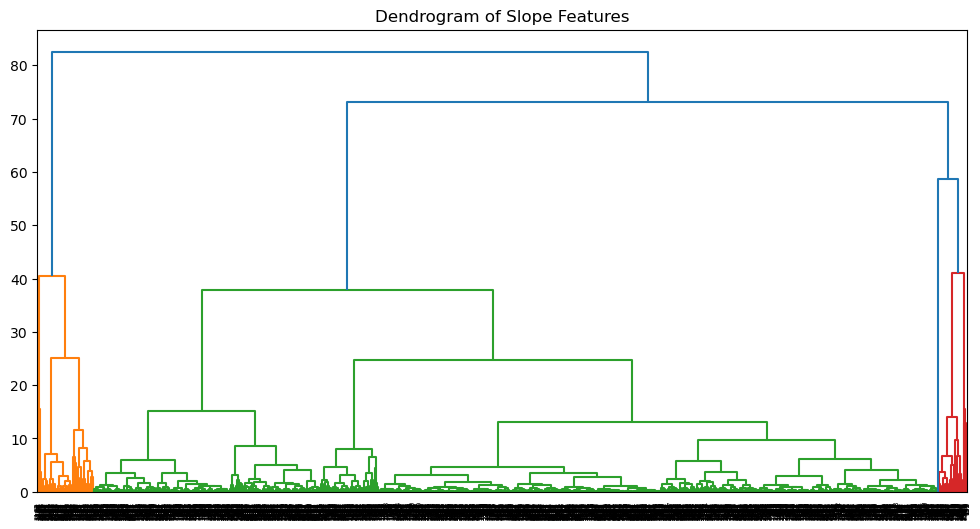

In [6]:
slope_link = linkage(slope_features_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(slope_link, labels=slope_features.index, leaf_rotation=90)
plt.title('Dendrogram of Slope Features')
plt.show()

### Step 3: Set Up Cluster Interpretation

After determining the optimal number of clusters from the dendrogram, we now assign each county to a cluster using the extracted cluster labels.

To better understand the clustering results, we will:
- Define `num_clusters` as the ideal number of clusters based on the dendrogram created above
- Extract cluster assignment attribute from the hierarchical clustering using `fcluster()` with `criterion = "maxclust"`
- Create a new variable `Cluster` in your cleaned dataframe and assign cluster labels to it
- Compute and print the mean values of the original energy potential features for each cluster.

This summary will help us interpret how counties differ in energy potential across clusters and inform possible next steps for analysis.


In [7]:
num_clusters = 4

caa = fcluster(slope_link, num_clusters, criterion = "maxclust")

slope_features["Cluster"] = caa
slope_features_scaled["Cluster"] = caa

og_cluster_mean = slope_features.groupby('Cluster').mean().reset_index()
scaled_cluster_mean = slope_features_scaled.groupby('Cluster').mean().reset_index()

print(f"Original mean energy potential feature values per cluster:")
print()
print(og_cluster_mean.to_markdown())
print("\n")

print(f"Scaled mean energy potential feature values per cluster:")
print()
print(scaled_cluster_mean.to_markdown())

Original mean energy potential feature values per cluster:

|    |   Cluster |   utility_pv_technical_generation_potential_mwh |   residential_pv_technical_generation_potential_mwh |   land_based_wind_technical_generation_potential_mwh |   commercial_pv_technical_generation_potential_mwh |
|---:|----------:|------------------------------------------------:|----------------------------------------------------:|-----------------------------------------------------:|---------------------------------------------------:|
|  0 |         1 |                                     3.29082e+08 |                                     84339.3         |                                          5.42242e+07 |                                    89428.4         |
|  1 |         2 |                                     4.94304e+07 |                                    122893           |                                          7.09061e+06 |                                   180186           |
|  2 |         3

### Step 4: Visualizing Energy Potential Across Clusters
Now that we have assigned cluster labels, we want to understand how energy potential differs across clusters. To do this, we will visualize these differences using a grouped bar chart.

Each bar should represent the mean value of an energy potential indicator for a specific cluster. These different patterns of potential is what caused the model to segregate the clusters in the way that it did.

In [8]:
scaled_cluster_melt = scaled_cluster_mean.melt(id_vars=["Cluster"], var_name="Type of Potential", value_name="Mean")
scaled_cluster_melt

,Cluster,Type of Potential,Mean
0,1,utility_pv_technical_generation_potential_mwh,2.831068
1,2,utility_pv_technical_generation_potential_mwh,-0.184742
2,3,utility_pv_technical_generation_potential_mwh,-0.076363
3,4,utility_pv_technical_generation_potential_mwh,-0.661236
4,1,residential_pv_technical_generation_potential_mwh,-0.193351
5,2,residential_pv_technical_generation_potential_mwh,-0.121549
6,3,residential_pv_technical_generation_potential_mwh,3.631745
7,4,residential_pv_technical_generation_potential_mwh,26.888227
8,1,land_based_wind_technical_generation_potential...,3.004580
9,2,land_based_wind_technical_generation_potential...,-0.185776


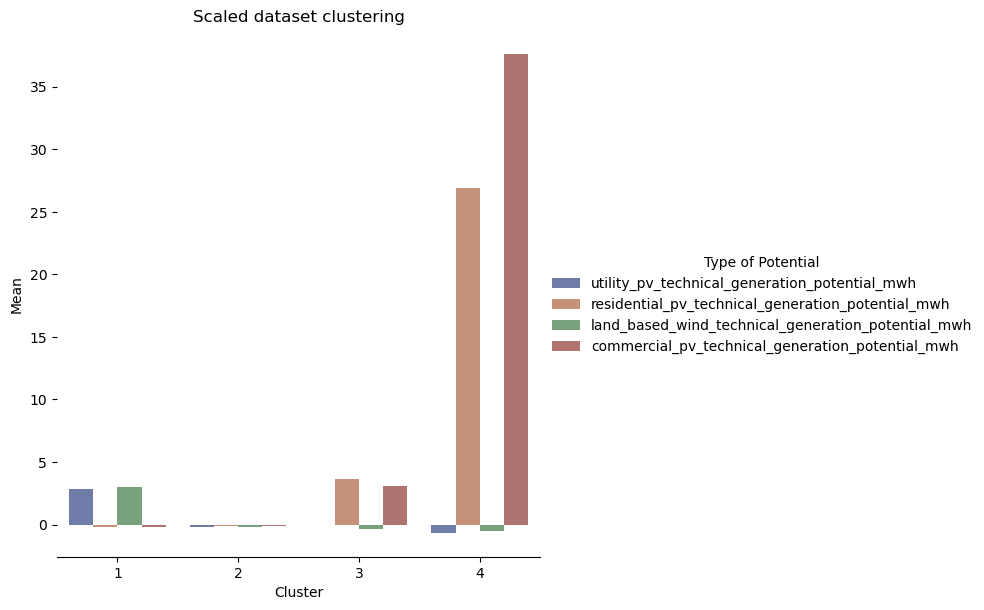

In [19]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scaled_cluster_melt, kind="bar",
    x="Cluster", y="Mean", hue="Type of Potential",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("Cluster", "Mean")
g.legend.set_title("Type of Potential")
g.set(title="Scaled dataset clustering")

In [15]:
og_cluster_melt = og_cluster_mean.melt(id_vars=["Cluster"], var_name="Type of Potential", value_name="Mean")
og_cluster_melt

,Cluster,Type of Potential,Mean
0,1,utility_pv_technical_generation_potential_mwh,3.290819e+08
1,2,utility_pv_technical_generation_potential_mwh,4.943040e+07
2,3,utility_pv_technical_generation_potential_mwh,5.948022e+07
3,4,utility_pv_technical_generation_potential_mwh,5.245800e+06
4,1,residential_pv_technical_generation_potential_mwh,8.433934e+04
5,2,residential_pv_technical_generation_potential_mwh,1.228932e+05
6,3,residential_pv_technical_generation_potential_mwh,2.138205e+06
7,4,residential_pv_technical_generation_potential_mwh,1.462565e+07
8,1,land_based_wind_technical_generation_potential...,5.422419e+07
9,2,land_based_wind_technical_generation_potential...,7.090613e+06


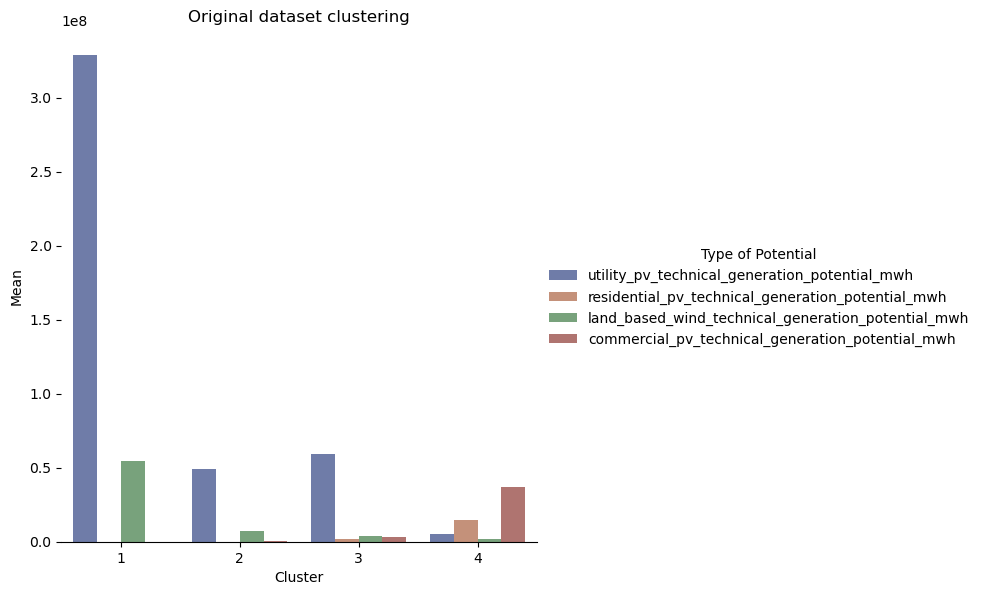

In [20]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=og_cluster_melt, kind="bar",
    x="Cluster", y="Mean", hue="Type of Potential",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("Cluster", "Mean")
g.legend.set_title("Type of Potential")
g.set(title="Original dataset clustering")

### Step 5: Interpret Clustering Results
Interpret your plot of the resulting clusters.  How would you characterize and compare the four different clusters in terms of their profile of energy generation?

In the clustering of the original data set means, we see utility have the greatest variance, especially in county cluster 1. However, in the scaled data, we find that there is a high devience in cluster 4, especially in the residential and commerical potential. Multiple inferences can be derrived from this.

 This means that overall, utility is has a higher absolute mean mwh, however, when commerical generation is utilized, it is used at a much higher scale, which is visible in cluster 4. This means certian counties specilize in different industries.

## Part II: Environmental Justice Metrics
Now it's your turn.

So far, we have clustered counties based on **energy potential**, but energy potential alone does not tell the full story of **energy equity and access**. To deepen the analysis, we need to consider environmental justice (EJ) factors that affect communities’ ability to benefit from renewable energy and the environmental burdens they already experience.

1. Explore EJSCREEN variables:  
   - The EJSCREEN subset of our dataset contains metrics on pollution burden, demographics (population size), and health risks (*lines 31-41 of the ColumnsExplained tab in the metadata sheet linked above*).
   - Identify 1-3 variables that could be important for energy equity analysis.  You could introduce them either as clustering features, as post-clustering variables to help interpret the clusters, or both. 

2. Modify the clustering approach:  
   - Add your selected EJSCREEN variables to our feature set.    
   - Re-run the hierarchical clustering analysis with the expanded dataset (if you added any as clustering features).  

3. Interpret the Results:
   Your interpretation could include considerations such as:
   - How do clusters change when EJSCREEN variables are included?  
   - Are counties with high renewable energy potential also burdened by environmental risks?  
   - What policy recommendations might emerge from these findings?  

In [31]:
eeip_data.columns[-20:]

Index(['wastewaterdischarge_4_prop', 'wastewaterdischarge_5_prop',
       'npl_indicator', 'nplprox_1_prop', 'nplprox_2_prop', 'nplprox_3_prop',
       'nplprox_4_prop', 'nplprox_5_prop', 'rmp_indicator', 'rmpprox_1_prop',
       'rmpprox_2_prop', 'rmpprox_3_prop', 'rmpprox_4_prop', 'rmpprox_5_prop',
       'tsdf_indicator', 'tsdfprox_1_prop', 'tsdfprox_2_prop',
       'tsdfprox_3_prop', 'tsdfprox_4_prop', 'tsdfprox_5_prop'],
      dtype='object')

In [32]:
# explore
EJ_features = eeip_data[[
    # Prop low income
    "lowincome_indicator",
    # Proximity to national priority list proportion
    "nplprox_1_prop",
    # Prop less than hs education
    "lessthanhs_indicator"
    ]]


Apply same transformations

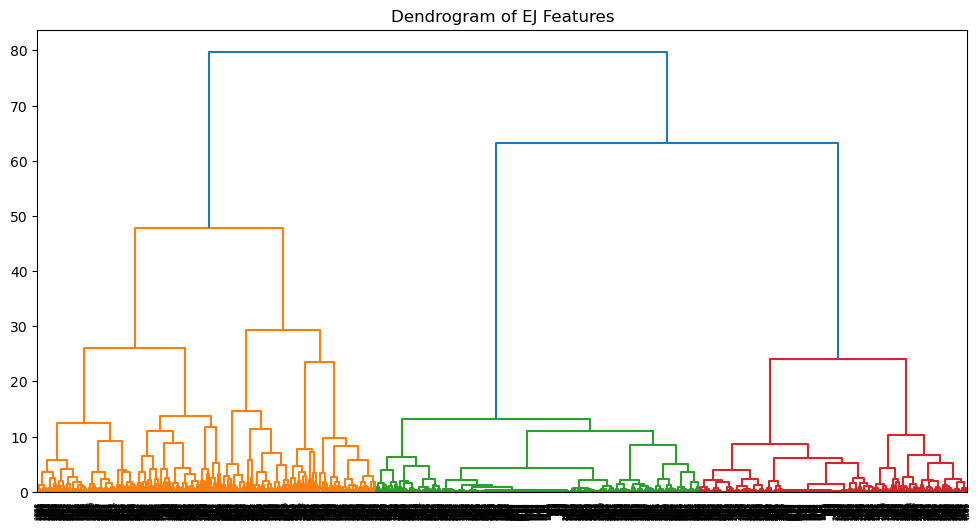

In [34]:
# Drop incomplete rows
EJ_features = EJ_features.dropna()
EJ_features_columns = EJ_features.columns

# Scale the data
scaler = StandardScaler()
EJ_features_scaled = scaler.fit_transform(EJ_features)

EJ_features_scaled = pd.DataFrame(EJ_features_scaled, columns=EJ_features_columns)

EJ_link = linkage(EJ_features_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(EJ_link, labels=EJ_features.index, leaf_rotation=90)
plt.title('Dendrogram of EJ Features')
plt.show()

In [47]:
EJ_num_clusters = 3

EJ_caa = fcluster(EJ_link, EJ_num_clusters, criterion = "maxclust")

EJ_features["Cluster"] = EJ_caa
EJ_features_scaled["Cluster"] = EJ_caa

EJ_og_cluster_mean = EJ_features.groupby('Cluster').mean().reset_index()
EJ_scaled_cluster_mean = EJ_features_scaled.groupby('Cluster').mean().reset_index()

print(f"Original EJ feature values per cluster:")
print()
print(EJ_og_cluster_mean.to_markdown())
print("\n")

print(f"Scaled EJ feature values per cluster:")
print()
print(EJ_scaled_cluster_mean.to_markdown())

Original EJ feature values per cluster:

|    |   Cluster |   lowincome_indicator |   nplprox_1_prop |   lessthanhs_indicator |
|---:|----------:|----------------------:|-----------------:|-----------------------:|
|  0 |         1 |             0.419565  |        0.518449  |              0.614855  |
|  1 |         2 |             0.0527917 |        0.0766473 |              0.0583698 |
|  2 |         3 |             0.14048   |        0.966223  |              0.106371  |


Scaled EJ feature values per cluster:

|    |   Cluster |   lowincome_indicator |   nplprox_1_prop |   lessthanhs_indicator |
|---:|----------:|----------------------:|-----------------:|-----------------------:|
|  0 |         1 |              0.909694 |        0.0552866 |               0.978611 |
|  1 |         2 |             -0.693988 |       -0.927157  |              -0.622359 |
|  2 |         3 |             -0.31058  |        1.05101   |              -0.484264 |


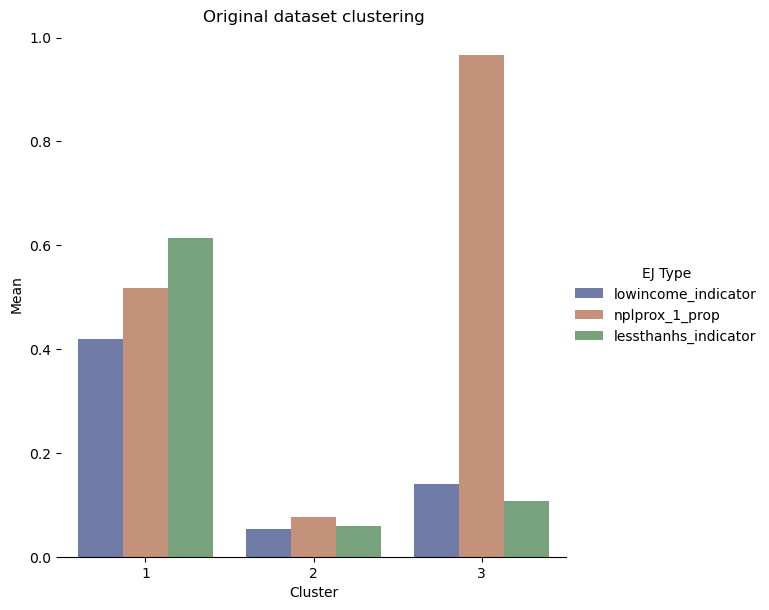

In [48]:
EJ_og_cluster_melt = EJ_og_cluster_mean.melt(id_vars=["Cluster"], var_name="EJ Type", value_name="Mean").reset_index()
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=EJ_og_cluster_melt, kind="bar",
    x="Cluster", y="Mean", hue="EJ Type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("Cluster", "Mean")
g.legend.set_title("EJ Type")
g.set(title="Original dataset clustering")

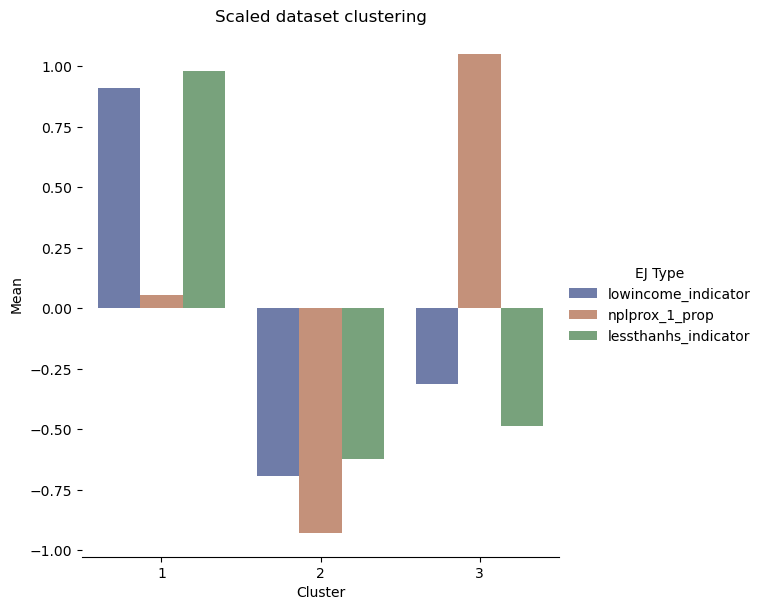

In [49]:
EJ_scaled_cluster_melt = EJ_scaled_cluster_mean.melt(id_vars=["Cluster"], var_name="EJ Type", value_name="Mean").reset_index()
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=EJ_scaled_cluster_melt, kind="bar",
    x="Cluster", y="Mean", hue="EJ Type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("Cluster", "Mean")
g.legend.set_title("EJ Type")
g.set(title="Scaled dataset clustering")

In [52]:
pd.crosstab(slope_features["Cluster"], EJ_features["Cluster"])

Cluster,1,2,3
Cluster,,,
1,68,17,102
2,1045,996,781
3,18,67,12
4,0,1,0


Which EJSCREEN variable(s) did you add to the analysis? Why did you choose these?  What is the question you are interested in? What did you learn from the analysis

The EJSCREEN variables added to the analysis were lowincome_indicator, nplprox_1_prop (proximity to National Priority List hazardous waste sites), and lessthanhs_indicator (percentage of the population with less than a high school education). These variables were chosen because they represent key environmental justice factors: economic disadvantage, exposure to environmental hazards, and educational attainment, which can impact access to renewable energy and environmental burdens.

I wanted to explore if counties with high renewable energy potential also burdened by environmental risks if socio-economic factors influence access to clean energy.

Some counties with high renewable energy potential also had higher environmental burdens, particularly in proximity to hazardous sites. Additionally, clusters with lower income and education levels tended to be distinct from those with high renewable energy generation potential. One interesting cluster of note, is county 3 in the scaled data. Though they had a lower mean of less than high school education and had a lower mean of those with lower income, they were more likley to be in the 90th percentile of proximity to national priority list sites, which is not often the trend across most counties. 